In [14]:
%matplotlib inline

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from quantumreservoirpy.reservoirs import Static
from quantumreservoirpy.plot import state_plotter
from quantumreservoirpy import util

from qiskit.providers.fake_provider import FakeManilaV2

from qiskit.circuit.library.standard_gates import HGate, SGate, CXGate, RC3XGate
backend = FakeManilaV2()


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier

models = np.array([
    SVC(kernel=ker) for ker in ['linear', 'poly', 'rbf', 'sigmoid']
] + [
    RidgeClassifier(alpha=alph) for alph in np.linspace(0, 1e-3, 20)
] + [
    KNeighborsClassifier(n_neighbors=n) for n in range(1, 10)
], dtype=object)

In [17]:
import numpy as np

encoder={
        0: '00',
        1: '01',
        2: '10',
        3: '11'
    }

class RandomClifford(Static):
    def __init__(self, n_qubits, memory=np.inf, backend=None) -> None:
        super().__init__(n_qubits, memory, backend)

        circop = util.random_circuit(n_qubits, gates=[
            HGate, SGate, CXGate#, TGate
        ], depth=40)

        self.op = circop.to_gate(label='RES')
    
    def before(self, circuit):
        circuit.h(circuit.qubits)
    
    def during(self, circuit, timestep):
        circuit.measure(range(3))
        circuit.initialize(encoder[timestep], [0, 1])
        circuit.append(self.op,circuit.qubits)
        


In [18]:
n_qubits = backend.num_qubits
shots = 100
timeseries = [0, 1] * 30


In [19]:
res = RandomClifford(n_qubits=n_qubits, backend=backend)

states = res.run(timeseries, shots=shots, transpile=True)



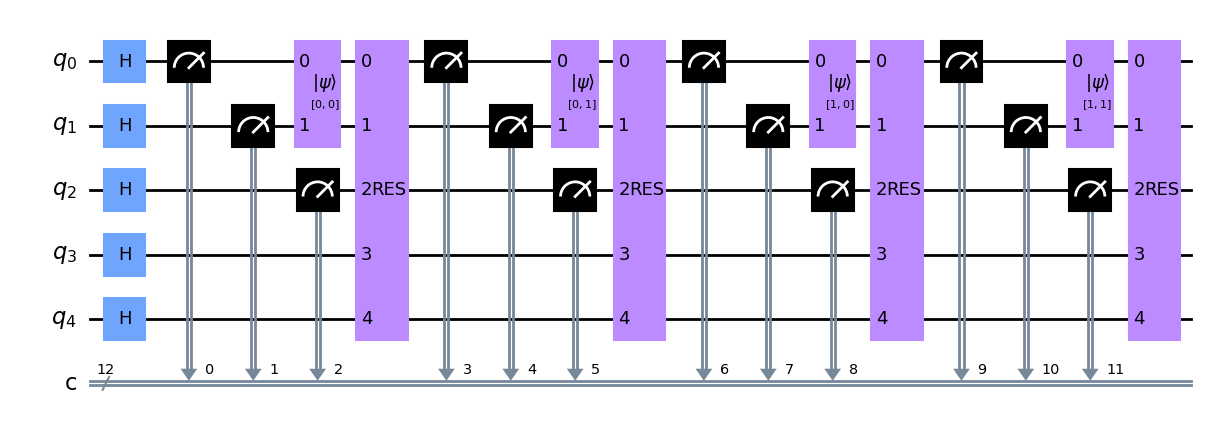

In [20]:
res.circuit([0, 1, 2, 3], merge_registers=True, transpile=False).draw('mpl')

In [21]:
WARMUP = 0.1
warmup_idx = int(len(states) * WARMUP)
xstates = states[:-1][warmup_idx:]
target = timeseries[1:][warmup_idx:]



In [22]:

results = util.stress_test_models(xstates, target, models)
print(results)

[0.42444444 0.44166667 0.49       0.42444444 0.48944444 0.48944444
 0.48944444 0.48944444 0.48944444 0.48944444 0.48944444 0.48944444
 0.48944444 0.48944444 0.48944444 0.48944444 0.48944444 0.48944444
 0.48944444 0.48888889 0.48888889 0.48888889 0.48888889 0.48944444
 0.49111111 0.49777778 0.47166667 0.47277778 0.48666667 0.47166667
 0.49111111 0.47055556 0.50388889]


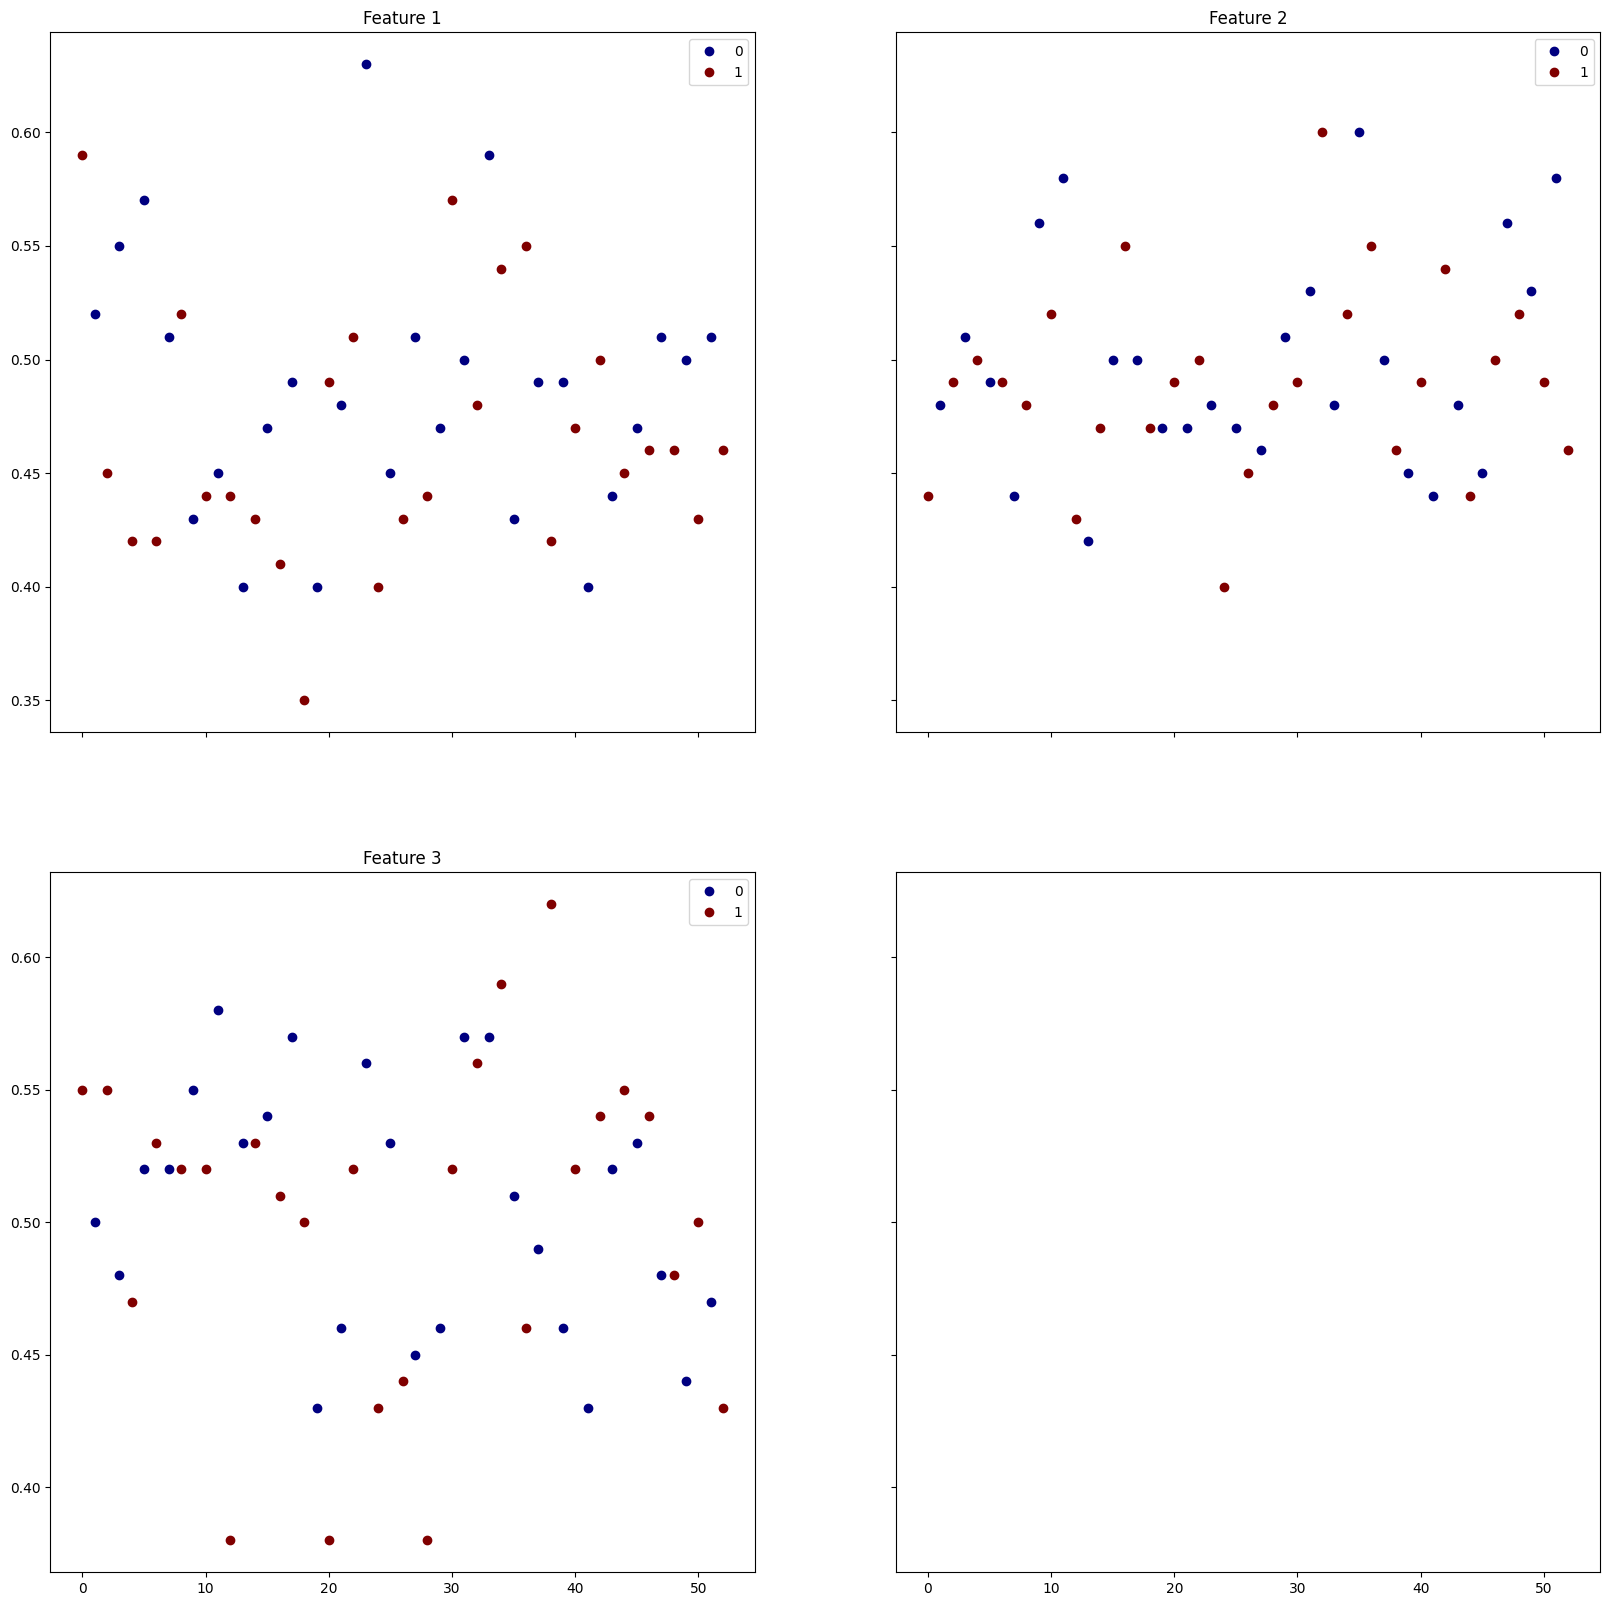

In [23]:
fig ,axes = state_plotter(xstates, target)



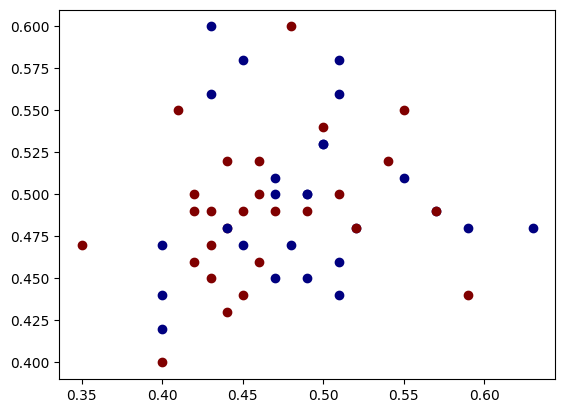

In [24]:
cmap = plt.get_cmap('jet', len(np.unique(target)))
for elem, x, y in zip(target, xstates[:, 0], xstates[:, 1]):
    plt.scatter(x, y, color=cmap(elem))

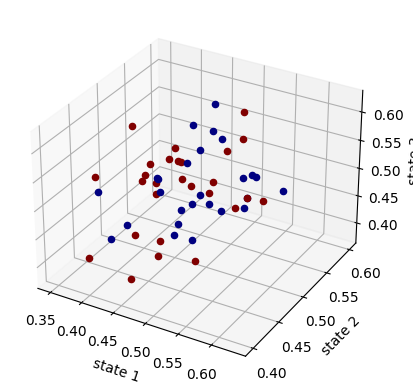

In [25]:
if xstates.shape[-1] >= 3:
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    cmap = plt.get_cmap('jet', len(np.unique(timeseries)))
    for i, x, y, z in zip(target, xstates[:, 0], xstates[:, 1], xstates[:, 2]):
        ax.scatter(x, y, z, color=cmap(i))
    ax.set_xlabel('state 1')
    ax.set_ylabel('state 2')
    ax.set_zlabel('state 3')
    